In [370]:
# Importing libraries
import pandas as pd
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.svm import SVR # SVM for regression
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

# Data

sleepdata_2.csv was not used, because Notes were missing. Heart rate was pruned due to low number of observations --> observations only when there is not activity steps. Same for wake up.

# Exploratory Data Analysis

### sleepdata.csv (Dataset 1)

In [371]:
# Dataset
sleepdata = pd.read_csv("sleepdata.csv", sep = ";")

row, col = sleepdata.shape

print("The first dataset contains", row, "rows and", col, "columns.")

The first dataset contains 887 rows and 8 columns.


In [372]:
sleepdata.head()

,Start,End,Sleep quality,Time in bed,Wake up,Sleep Notes,Heart rate,Activity (steps)
0,2014-12-29 22:57:49,2014-12-30 07:30:13,100%,8:32,:),NaN,59.0,0
1,2014-12-30 21:17:50,2014-12-30 21:33:54,3%,0:16,:|,Stressful day,72.0,0
2,2014-12-30 22:42:49,2014-12-31 07:13:31,98%,8:30,:|,NaN,57.0,0
3,2014-12-31 22:31:01,2015-01-01 06:03:01,65%,7:32,NaN,NaN,NaN,0
4,2015-01-01 22:12:10,2015-01-02 04:56:35,72%,6:44,:),Drank coffee:Drank tea,68.0,0


In [373]:
sleepdata.dtypes

Start                object
End                  object
Sleep quality        object
Time in bed          object
Wake up              object
Sleep Notes          object
Heart rate          float64
Activity (steps)      int64
dtype: object

In [374]:
sleepdata.isnull().sum(axis = 0)

Start                 0
End                   0
Sleep quality         0
Time in bed           0
Wake up             641
Sleep Notes         235
Heart rate          725
Activity (steps)      0
dtype: int64

### sleepdata_2.csv (Dataset 2)

In [375]:
# Dataset
sleepdata2 = data = pd.read_csv("sleepdata_2.csv", sep = ";")

row, col = sleepdata2.shape

print("The second dataset contains", row, "rows and", col, "columns")

The second dataset contains 921 rows and 21 columns


In [376]:
sleepdata2.isnull().sum(axis = 0)

Start                            0
End                              0
Sleep Quality                    0
Regularity                       0
Mood                           921
Heart rate (bpm)                 0
Steps                            0
Alarm mode                       0
Air Pressure (Pa)              429
City                           434
Movements per hour               0
Time in bed (seconds)            0
Time asleep (seconds)            0
Time before sleep (seconds)      0
Window start                    80
Window stop                     80
Did snore                        0
Snore time                       0
Weather temperature (°C)         0
Weather type                     0
Notes                          912
dtype: int64

# Data Pre-processing

In [507]:
data_cleaned = sleepdata.copy()

# Dropping columns "Start", "End", "Wake up" "Heart rate"
data_cleaned = data_cleaned.drop(["End", "Wake up", "Heart rate"], axis = 1)

# Dropping rows where "Sleep quality", "Sleep Notes" or is NA
data_cleaned = data_cleaned.dropna(subset = ["Sleep quality", "Sleep Notes"])

# Droppin rows where "Activity (steps)" is zero
data_cleaned.drop(data_cleaned[data_cleaned["Activity (steps)"] == 0].index, inplace = True)

# Modifying "Time in bed" into minutes
data_cleaned = data_cleaned.reset_index(drop=True)

for row in range(data_cleaned.shape[0]):
    str_time = data_cleaned["Time in bed"][row]
    if str_time[1] == ":":
        data_cleaned["Time in bed"][row] = int(int(data_cleaned["Time in bed"][row][0]) * 60 + int(data_cleaned["Time in bed"][row][2:4]))
    else:
        data_cleaned["Time in bed"][row] = int(data_cleaned["Time in bed"][row][0:2]) * 60 + int(data_cleaned["Time in bed"][row][3:5])

# Modifying "Sleep quality" into an integer and "Time in bed into a numeric"
data_cleaned["Sleep quality"] = data_cleaned["Sleep quality"].apply(lambda row: int(row[:-1]))
data_cleaned["Time in bed"] = pd.to_numeric(data_cleaned["Time in bed"])

# Creating Weekend Feature
data_cleaned["Start"] = pd.to_datetime(data_cleaned["Start"]).dt.dayofweek
data_cleaned["Weekend"] = data_cleaned["Start"].apply(lambda row: int(row == 6 or row == 7))
data_cleaned = data_cleaned.drop(["Start"], axis = 1)


# The number of remaining rows
print("The number of remaining rows is", data_cleaned.shape[0])

# Showing the results
data_cleaned.head()

data_cleaned

The number of remaining rows is 254


,Sleep quality,Time in bed,Sleep Notes,Activity (steps),Weekend
0,78,453,Ate late:Drank coffee:Worked out,7200,0
1,36,504,Drank coffee:Worked out,3444,0
2,56,628,Drank coffee,7901,0
3,52,491,Drank coffee:Drank tea,3786,1
4,35,489,Drank coffee:Worked out,2668,0
...,...,...,...,...,...
249,67,426,Drank coffee,6705,1
250,74,467,Drank coffee:Worked out,7820,0
251,76,494,Drank coffee:Drank tea:Stressful day:Worked out,5391,0
252,41,460,Drank coffee:Drank tea:Worked out,10542,0


In [508]:
# Encoding Sleep Notes into variables

data_cleaned["Sleep Notes"].value_counts()

Drank coffee:Drank tea                             63
Drank coffee:Drank tea:Worked out                  61
Drank tea                                          38
Drank tea:Worked out                               34
Drank coffee:Worked out                            22
Drank coffee                                       19
Drank coffee:Drank tea:Stressful day                4
Drank coffee:Drank tea:Stressful day:Worked out     3
Ate late:Drank coffee:Worked out                    2
Drank tea:Stressful day:Worked out                  2
Drank coffee:Stressful day:Worked out               2
Ate late:Drank coffee:Drank tea:Worked out          2
Drank coffee:Stressful day                          1
Ate late:Drank coffee:Drank tea                     1
Name: Sleep Notes, dtype: int64

In [509]:
# Coffee
data_cleaned["Coffee"] = data_cleaned["Sleep Notes"].apply(lambda row: int("coffee" in row))

# Tea
data_cleaned["Tea"] = data_cleaned["Sleep Notes"].apply(lambda row: int("tea" in row))

# Working out
data_cleaned["Working out"] = data_cleaned["Sleep Notes"].apply(lambda row: int("Worked" in row))

# Late eating
data_cleaned["Late eating"] = data_cleaned["Sleep Notes"].apply(lambda row: int("Ate late" in row))

# Stress
data_cleaned["Stress"] = data_cleaned["Sleep Notes"].apply(lambda row: int("Stressful" in row))

# Dropping "Sleep Notes"g
data_cleaned = data_cleaned.drop(["Sleep Notes"], axis = 1)

data_cleaned.head()

,Sleep quality,Time in bed,Activity (steps),Weekend,Coffee,Tea,Working out,Late eating,Stress
0,78,453,7200,0,1,0,1,1,0
1,36,504,3444,0,1,0,1,0,0
2,56,628,7901,0,1,0,0,0,0
3,52,491,3786,1,1,1,0,0,0
4,35,489,2668,0,1,0,1,0,0


# Feature Selection

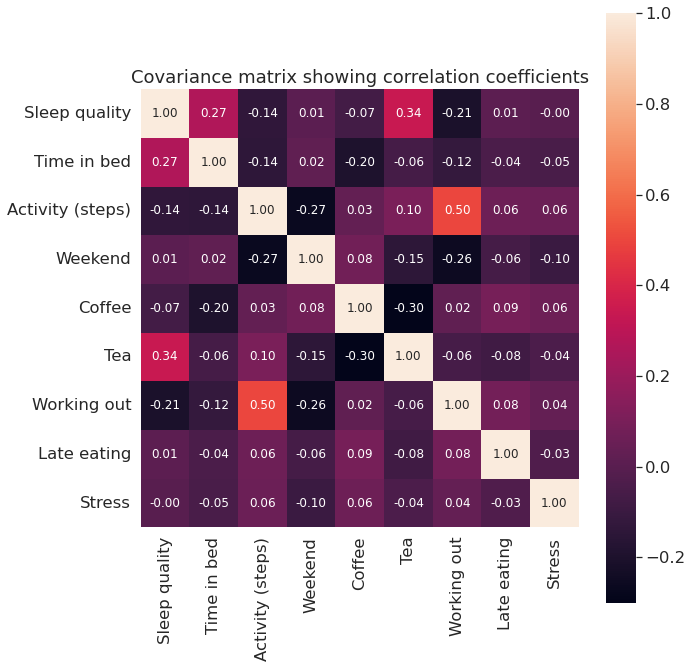

In [510]:
# Covariance matrix
plt.figure(figsize=(10,10))
sns.set(font_scale=1.5)
hm = sns.heatmap(data_cleaned.corr(),
                 cbar=True,
                 annot=True,
                 square=True,
                 fmt='.2f',
                 annot_kws={'size': 12})
plt.title('Covariance matrix showing correlation coefficients')
plt.tight_layout() 
plt.show() 

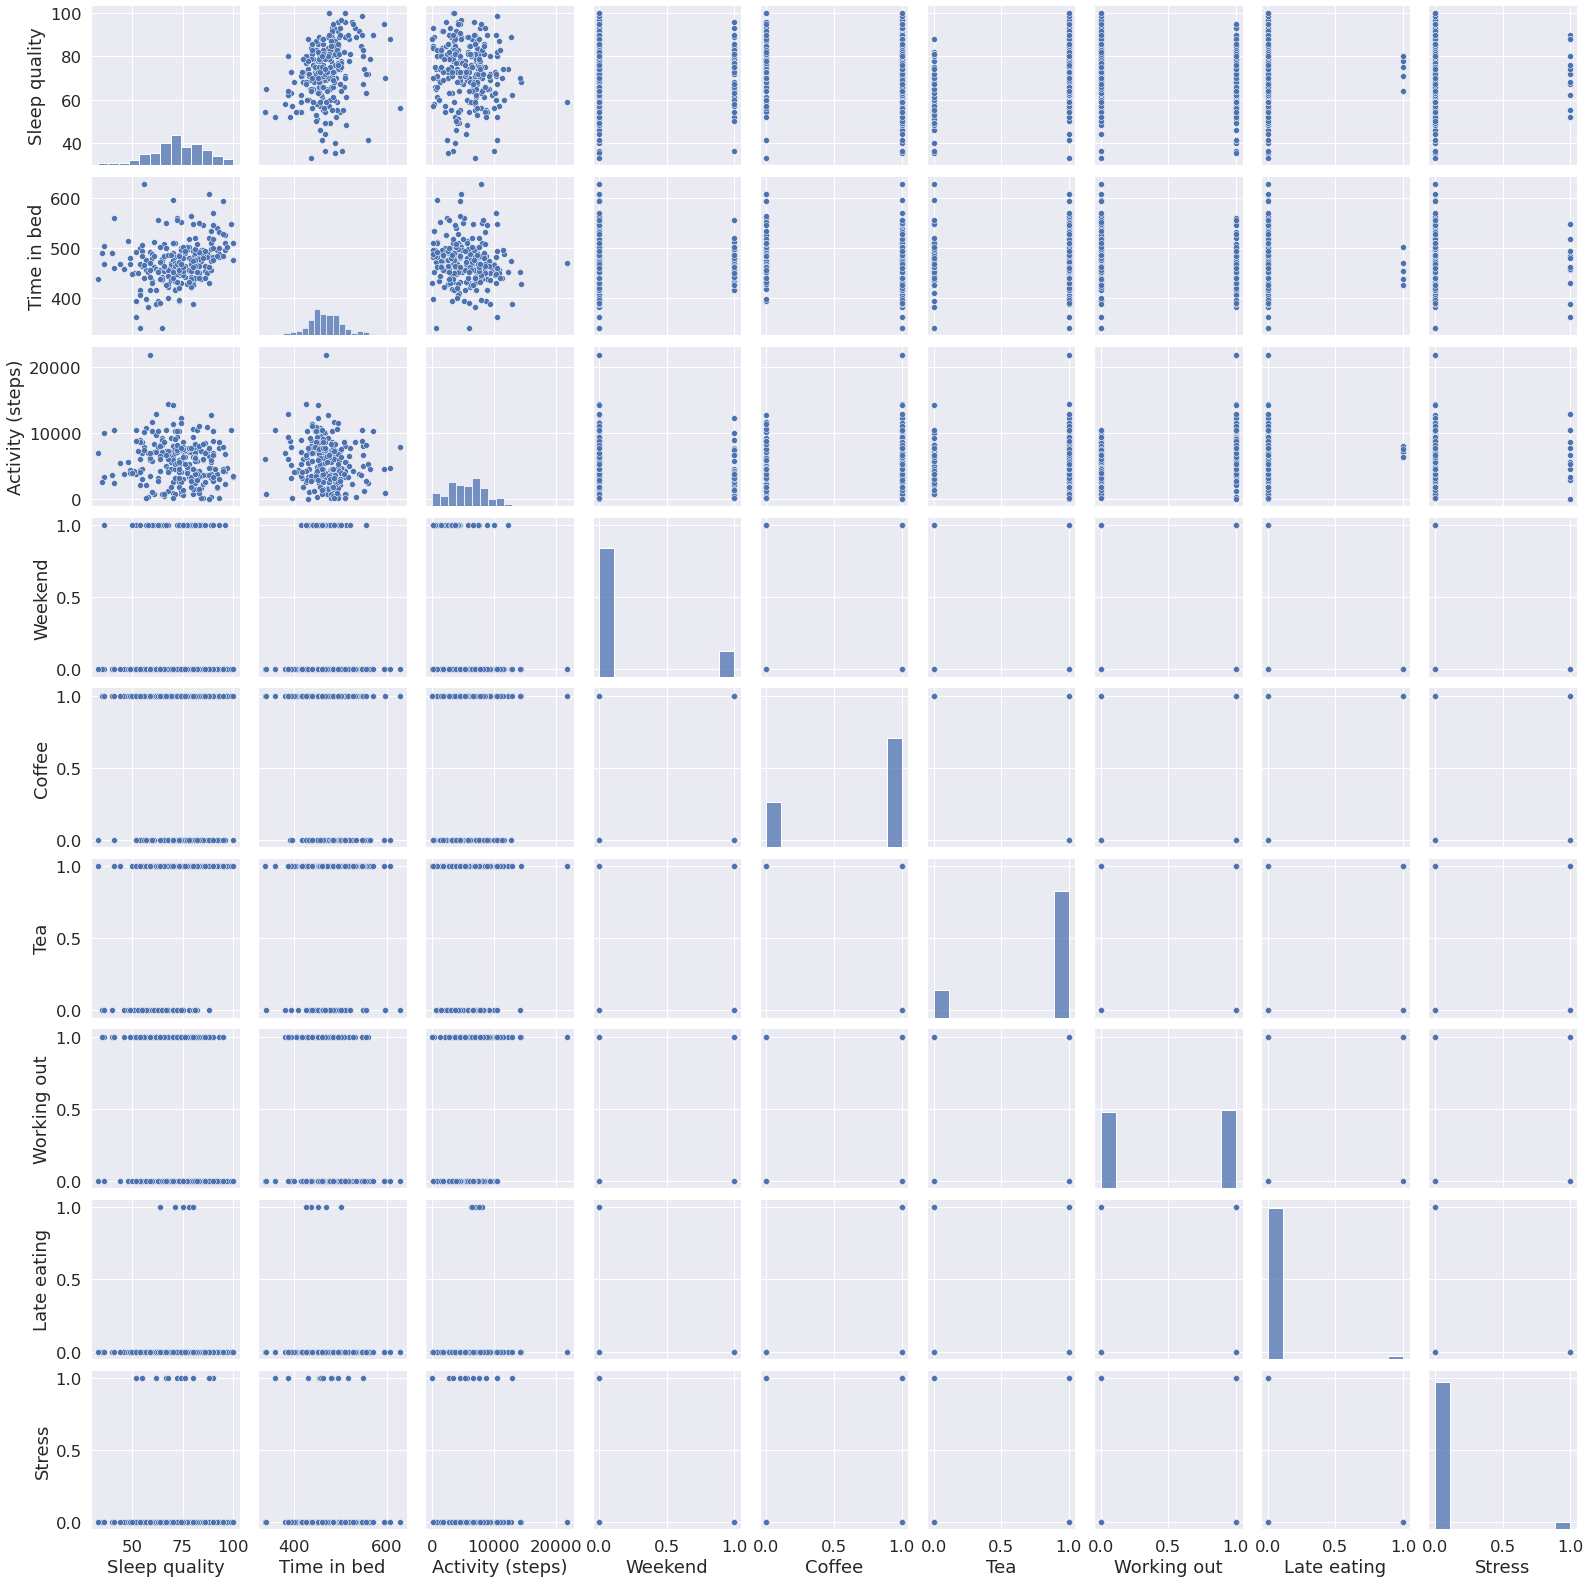

In [511]:
sns.pairplot(data_cleaned)

## Wrapper Method for Feature Selection

In [513]:
y = data_cleaned.iloc[:, 0]
X = data_cleaned.iloc[:, 1:]

# Scaling
scaler = StandardScaler()
X_names = list(X.columns.values)
X = pd.DataFrame(scaler.fit_transform(X))
X.columns = X_names

# Regressors
lin_reg = LinearRegression()
svr = SVR()

# Sequential feature selection
lin_reg_sfs = SequentialFeatureSelector(lin_reg)
svr_sfs = SequentialFeatureSelector(svr)

lin_reg_sfs.fit(X, y)
svr_sfs.fit(X, y)

SequentialFeatureSelector(estimator=LinearRegression(), direction = "backward")
SequentialFeatureSelector(estimator=SVR(), direction = "backward")

print("The proposed variables with the linear regression are:", lin_reg_sfs.get_feature_names_out())
print("The proposed variables with the support vector regressor are:", svr_sfs.get_feature_names_out())

The proposed variables with the linear regression are: ['Time in bed' 'Activity (steps)' 'Tea' 'Working out']
The proposed variables with the support vector regressor are: ['Time in bed' 'Weekend' 'Tea' 'Late eating']
